## This jupyter notebook shows how we reimplement the experiment on non-robust features

In [1]:
from __future__ import print_function
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms
from torch.autograd import Variable

from utils import *
from attack_functions import *
from resnet_cifar import resnet20_cifar
from resnet_cifar import resnet56_cifar
from tqdm import tqdm, trange

import logging
import os
import sys

import torchvision.utils
import matplotlib.pyplot as plt

In [2]:
# Training settings
name = 'cifar10'
batch_size = 128
test_batch_size = 200
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [3]:
model = resnet56_cifar()
model = torch.nn.DataParallel(model)
print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

# get dataset
train_loader, test_loader = getData(name=name, train_bs=batch_size, test_bs=test_batch_size)

    Total params: 0.86M
Files already downloaded and verified


In [4]:
file_path = './checkpoint/resnet56_cifar10.ckpt'

In [5]:
model.load_state_dict(torch.load(f"{file_path}"))
test(model, test_loader)

Testing
testing_correct:  0.9142 



0.9142

In [6]:
def eval_model(model_tst, loader_tst, dataset_name):

    print("Test the model")

    model_tst.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader_tst:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_tst(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print(total)

        print('Test Accuracy of the model on the ' + dataset_name + ' : {} %'.format(100 * correct / total))
        
    return 100 * correct / total


In [7]:
criterion = nn.CrossEntropyLoss() 

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [9]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (10, 30))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [10]:
eval_model(model, test_loader, "original test images")

Test the model
Test Accuracy of the model on the original test images : 91.42 %


91.42

In [11]:
Test_list_log = []
batch_size = 200
learning_rate = 0.01

def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Attack part

In [13]:
PGD_attack = PGD_l2(model = model, eps = 10, iters=100, alpha = 2)
adv_data = PGD_attack.save(data_loader=train_loader, file_name="data/cifar_PGD_larger.pt", to_uint8=False, accuracy=True)

adv_loader = torch.utils.data.DataLoader(dataset = adv_data, batch_size=batch_size, shuffle=True)

- Save Progress : 0.26 %        
- Accuracy of the model : 0.000000 %- Save Progress : 0.51 %        
- Accuracy of the model : 0.000000 %- Save Progress : 0.77 %        
- Accuracy of the model : 0.000000 %- Save Progress : 1.02 %        
- Accuracy of the model : 0.000000 %- Save Progress : 1.28 %        
- Accuracy of the model : 0.000000 %- Save Progress : 1.53 %        
- Accuracy of the model : 0.000000 %- Save Progress : 1.79 %        
- Accuracy of the model : 0.000000 %- Save Progress : 2.05 %        
- Accuracy of the model : 0.000000 %- Save Progress : 2.30 %        
- Accuracy of the model : 0.000000 %- Save Progress : 2.56 %        
- Accuracy of the model : 0.000000 %- Save Progress : 2.81 %        
- Accuracy of the model : 0.000000 %- Save Progress : 3.07 %        
- Accuracy of the model : 0.000000 %- Save Progress : 3.32 %        
- Accuracy of the model : 0.000000 %- Save Progress : 3.58 %        
- Accuracy of the model : 0.000000 %- Save Progress : 3.84 %        
-

- Accuracy of the model : 0.000000 %- Save Progress : 60.36 %        
- Accuracy of the model : 0.000000 %- Save Progress : 60.61 %        
- Accuracy of the model : 0.000000 %- Save Progress : 60.87 %        
- Accuracy of the model : 0.000000 %- Save Progress : 61.13 %        
- Accuracy of the model : 0.000000 %- Save Progress : 61.38 %        
- Accuracy of the model : 0.000000 %- Save Progress : 61.64 %        
- Accuracy of the model : 0.000000 %- Save Progress : 61.89 %        
- Accuracy of the model : 0.000000 %- Save Progress : 62.15 %        
- Accuracy of the model : 0.000000 %- Save Progress : 62.40 %        
- Accuracy of the model : 0.000000 %- Save Progress : 62.66 %        
- Accuracy of the model : 0.000000 %- Save Progress : 62.92 %        
- Accuracy of the model : 0.000000 %- Save Progress : 63.17 %        
- Accuracy of the model : 0.000000 %- Save Progress : 63.43 %        
- Accuracy of the model : 0.000000 %- Save Progress : 63.68 %        
- Accuracy of the mo

In [ ]:
for i, (images, labels) in enumerate(adv_loader):
    if i < 1 :
        print([np.min(images.data.numpy()), np.max(images.data.numpy())])
        imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), labels.cpu().numpy()) 
    else:
        break

In [15]:
model_adv = resnet20_cifar()
model_adv.fc = nn.Linear(64,10)
model_adv = model_adv.to(device)
model_adv = nn.DataParallel(model_adv)

In [16]:
optimizer_adv = torch.optim.SGD(model_adv.parameters(), lr=learning_rate, momentum=0.9,
                            weight_decay=0.0005, nesterov=True)
print("Train the confused model")
Loss_list = []
Test_list = []

num_epochs = 100

best_acc = 0
total_step = len(adv_loader)

for epoch in range(num_epochs):

    model_adv.train()
    if epoch > 75:
        lr = 0.0001
    elif epoch > 50:
        lr = 0.001
    else:
        lr = 0.01

    update_lr(optimizer_adv, lr)

    for i, (adv_images, adv_labels) in enumerate(adv_loader):

        # train
        adv_images = adv_images.to(device)
        adv_labels = adv_labels.to(device)

        outputs_adv = model_adv(adv_images)
        loss = criterion(outputs_adv, adv_labels)

        optimizer_adv.zero_grad()
        loss.backward()
        optimizer_adv.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            Loss_list.append(loss.item())

    if (epoch+1)%1 == 0:

        acc = eval_model(model_adv, test_loader, "original test set")

        Test_list.append(acc)

        if acc > best_acc:
            print('Saving model ' + '..')
            state = {
                'net': model_adv.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/resnet_adv_cifar_larger.pth')
            best_acc = acc

print(Test_list)

Train the confused model
Epoch [1/100], Step [10/250], Loss: 2.3224
Epoch [1/100], Step [20/250], Loss: 2.3163
Epoch [1/100], Step [30/250], Loss: 2.3286
Epoch [1/100], Step [40/250], Loss: 2.2897
Epoch [1/100], Step [50/250], Loss: 2.2900
Epoch [1/100], Step [60/250], Loss: 2.3107
Epoch [1/100], Step [70/250], Loss: 2.3180
Epoch [1/100], Step [80/250], Loss: 2.3134
Epoch [1/100], Step [90/250], Loss: 2.2995
Epoch [1/100], Step [100/250], Loss: 2.3080
Epoch [1/100], Step [110/250], Loss: 2.3154
Epoch [1/100], Step [120/250], Loss: 2.3154
Epoch [1/100], Step [130/250], Loss: 2.3221
Epoch [1/100], Step [140/250], Loss: 2.3127
Epoch [1/100], Step [150/250], Loss: 2.3084
Epoch [1/100], Step [160/250], Loss: 2.3286
Epoch [1/100], Step [170/250], Loss: 2.3038
Epoch [1/100], Step [180/250], Loss: 2.3110
Epoch [1/100], Step [190/250], Loss: 2.3053
Epoch [1/100], Step [200/250], Loss: 2.3004
Epoch [1/100], Step [210/250], Loss: 2.3101
Epoch [1/100], Step [220/250], Loss: 2.2962
Epoch [1/100], S

Epoch [8/100], Step [10/250], Loss: 2.2769
Epoch [8/100], Step [20/250], Loss: 2.2835
Epoch [8/100], Step [30/250], Loss: 2.2701
Epoch [8/100], Step [40/250], Loss: 2.2757
Epoch [8/100], Step [50/250], Loss: 2.2784
Epoch [8/100], Step [60/250], Loss: 2.2711
Epoch [8/100], Step [70/250], Loss: 2.2588
Epoch [8/100], Step [80/250], Loss: 2.2641
Epoch [8/100], Step [90/250], Loss: 2.2637
Epoch [8/100], Step [100/250], Loss: 2.2952
Epoch [8/100], Step [110/250], Loss: 2.3181
Epoch [8/100], Step [120/250], Loss: 2.2669
Epoch [8/100], Step [130/250], Loss: 2.2935
Epoch [8/100], Step [140/250], Loss: 2.2880
Epoch [8/100], Step [150/250], Loss: 2.3009
Epoch [8/100], Step [160/250], Loss: 2.2873
Epoch [8/100], Step [170/250], Loss: 2.2732
Epoch [8/100], Step [180/250], Loss: 2.3109
Epoch [8/100], Step [190/250], Loss: 2.2724
Epoch [8/100], Step [200/250], Loss: 2.2840
Epoch [8/100], Step [210/250], Loss: 2.2845
Epoch [8/100], Step [220/250], Loss: 2.2964
Epoch [8/100], Step [230/250], Loss: 2.30

Epoch [14/100], Step [250/250], Loss: 1.9392
Test the model
Test Accuracy of the model on the original test set : 21.88 %
Saving model ..
Epoch [15/100], Step [10/250], Loss: 1.7759
Epoch [15/100], Step [20/250], Loss: 1.8010
Epoch [15/100], Step [30/250], Loss: 1.8017
Epoch [15/100], Step [40/250], Loss: 1.7214
Epoch [15/100], Step [50/250], Loss: 1.7111
Epoch [15/100], Step [60/250], Loss: 1.6630
Epoch [15/100], Step [70/250], Loss: 1.8063
Epoch [15/100], Step [80/250], Loss: 1.6751
Epoch [15/100], Step [90/250], Loss: 1.6100
Epoch [15/100], Step [100/250], Loss: 1.6339
Epoch [15/100], Step [110/250], Loss: 1.5947
Epoch [15/100], Step [120/250], Loss: 1.6869
Epoch [15/100], Step [130/250], Loss: 1.6050
Epoch [15/100], Step [140/250], Loss: 1.6244
Epoch [15/100], Step [150/250], Loss: 1.7297
Epoch [15/100], Step [160/250], Loss: 1.5681
Epoch [15/100], Step [170/250], Loss: 1.6120
Epoch [15/100], Step [180/250], Loss: 1.6718
Epoch [15/100], Step [190/250], Loss: 1.5466
Epoch [15/100], 

Epoch [21/100], Step [200/250], Loss: 0.2734
Epoch [21/100], Step [210/250], Loss: 0.2811
Epoch [21/100], Step [220/250], Loss: 0.2462
Epoch [21/100], Step [230/250], Loss: 0.2488
Epoch [21/100], Step [240/250], Loss: 0.3106
Epoch [21/100], Step [250/250], Loss: 0.3168
Test the model
Test Accuracy of the model on the original test set : 57.47 %
Saving model ..
Epoch [22/100], Step [10/250], Loss: 0.1357
Epoch [22/100], Step [20/250], Loss: 0.1919
Epoch [22/100], Step [30/250], Loss: 0.1691
Epoch [22/100], Step [40/250], Loss: 0.2232
Epoch [22/100], Step [50/250], Loss: 0.1567
Epoch [22/100], Step [60/250], Loss: 0.2003
Epoch [22/100], Step [70/250], Loss: 0.1891
Epoch [22/100], Step [80/250], Loss: 0.1795
Epoch [22/100], Step [90/250], Loss: 0.2321
Epoch [22/100], Step [100/250], Loss: 0.1873
Epoch [22/100], Step [110/250], Loss: 0.2006
Epoch [22/100], Step [120/250], Loss: 0.2452
Epoch [22/100], Step [130/250], Loss: 0.2208
Epoch [22/100], Step [140/250], Loss: 0.1696
Epoch [22/100], 

Epoch [28/100], Step [170/250], Loss: 0.0408
Epoch [28/100], Step [180/250], Loss: 0.0482
Epoch [28/100], Step [190/250], Loss: 0.0602
Epoch [28/100], Step [200/250], Loss: 0.0632
Epoch [28/100], Step [210/250], Loss: 0.0752
Epoch [28/100], Step [220/250], Loss: 0.0524
Epoch [28/100], Step [230/250], Loss: 0.0564
Epoch [28/100], Step [240/250], Loss: 0.0600
Epoch [28/100], Step [250/250], Loss: 0.0542
Test the model
Test Accuracy of the model on the original test set : 58.47 %
Saving model ..
Epoch [29/100], Step [10/250], Loss: 0.0330
Epoch [29/100], Step [20/250], Loss: 0.0296
Epoch [29/100], Step [30/250], Loss: 0.0213
Epoch [29/100], Step [40/250], Loss: 0.0341
Epoch [29/100], Step [50/250], Loss: 0.0240
Epoch [29/100], Step [60/250], Loss: 0.0355
Epoch [29/100], Step [70/250], Loss: 0.0299
Epoch [29/100], Step [80/250], Loss: 0.0248
Epoch [29/100], Step [90/250], Loss: 0.0453
Epoch [29/100], Step [100/250], Loss: 0.0386
Epoch [29/100], Step [110/250], Loss: 0.0378
Epoch [29/100], 

Epoch [35/100], Step [130/250], Loss: 0.0037
Epoch [35/100], Step [140/250], Loss: 0.0058
Epoch [35/100], Step [150/250], Loss: 0.0041
Epoch [35/100], Step [160/250], Loss: 0.0046
Epoch [35/100], Step [170/250], Loss: 0.0047
Epoch [35/100], Step [180/250], Loss: 0.0040
Epoch [35/100], Step [190/250], Loss: 0.0051
Epoch [35/100], Step [200/250], Loss: 0.0057
Epoch [35/100], Step [210/250], Loss: 0.0037
Epoch [35/100], Step [220/250], Loss: 0.0049
Epoch [35/100], Step [230/250], Loss: 0.0041
Epoch [35/100], Step [240/250], Loss: 0.0044
Epoch [35/100], Step [250/250], Loss: 0.0031
Test the model
Test Accuracy of the model on the original test set : 63.0 %
Epoch [36/100], Step [10/250], Loss: 0.0033
Epoch [36/100], Step [20/250], Loss: 0.0056
Epoch [36/100], Step [30/250], Loss: 0.0027
Epoch [36/100], Step [40/250], Loss: 0.0028
Epoch [36/100], Step [50/250], Loss: 0.0031
Epoch [36/100], Step [60/250], Loss: 0.0039
Epoch [36/100], Step [70/250], Loss: 0.0056
Epoch [36/100], Step [80/250], 

Epoch [42/100], Step [100/250], Loss: 0.0025
Epoch [42/100], Step [110/250], Loss: 0.0035
Epoch [42/100], Step [120/250], Loss: 0.0024
Epoch [42/100], Step [130/250], Loss: 0.0025
Epoch [42/100], Step [140/250], Loss: 0.0038
Epoch [42/100], Step [150/250], Loss: 0.0034
Epoch [42/100], Step [160/250], Loss: 0.0025
Epoch [42/100], Step [170/250], Loss: 0.0026
Epoch [42/100], Step [180/250], Loss: 0.0033
Epoch [42/100], Step [190/250], Loss: 0.0031
Epoch [42/100], Step [200/250], Loss: 0.0024
Epoch [42/100], Step [210/250], Loss: 0.0035
Epoch [42/100], Step [220/250], Loss: 0.0026
Epoch [42/100], Step [230/250], Loss: 0.0024
Epoch [42/100], Step [240/250], Loss: 0.0044
Epoch [42/100], Step [250/250], Loss: 0.0027
Test the model
Test Accuracy of the model on the original test set : 63.87 %
Epoch [43/100], Step [10/250], Loss: 0.0036
Epoch [43/100], Step [20/250], Loss: 0.0037
Epoch [43/100], Step [30/250], Loss: 0.0020
Epoch [43/100], Step [40/250], Loss: 0.0027
Epoch [43/100], Step [50/25

Epoch [49/100], Step [70/250], Loss: 0.0022
Epoch [49/100], Step [80/250], Loss: 0.0031
Epoch [49/100], Step [90/250], Loss: 0.0035
Epoch [49/100], Step [100/250], Loss: 0.0034
Epoch [49/100], Step [110/250], Loss: 0.0029
Epoch [49/100], Step [120/250], Loss: 0.0034
Epoch [49/100], Step [130/250], Loss: 0.0055
Epoch [49/100], Step [140/250], Loss: 0.0024
Epoch [49/100], Step [150/250], Loss: 0.0039
Epoch [49/100], Step [160/250], Loss: 0.0020
Epoch [49/100], Step [170/250], Loss: 0.0029
Epoch [49/100], Step [180/250], Loss: 0.0027
Epoch [49/100], Step [190/250], Loss: 0.0027
Epoch [49/100], Step [200/250], Loss: 0.0031
Epoch [49/100], Step [210/250], Loss: 0.0038
Epoch [49/100], Step [220/250], Loss: 0.0059
Epoch [49/100], Step [230/250], Loss: 0.0033
Epoch [49/100], Step [240/250], Loss: 0.0050
Epoch [49/100], Step [250/250], Loss: 0.0049
Test the model
Test Accuracy of the model on the original test set : 63.02 %
Epoch [50/100], Step [10/250], Loss: 0.0040
Epoch [50/100], Step [20/25

Epoch [56/100], Step [40/250], Loss: 0.0034
Epoch [56/100], Step [50/250], Loss: 0.0017
Epoch [56/100], Step [60/250], Loss: 0.0031
Epoch [56/100], Step [70/250], Loss: 0.0030
Epoch [56/100], Step [80/250], Loss: 0.0027
Epoch [56/100], Step [90/250], Loss: 0.0024
Epoch [56/100], Step [100/250], Loss: 0.0024
Epoch [56/100], Step [110/250], Loss: 0.0022
Epoch [56/100], Step [120/250], Loss: 0.0031
Epoch [56/100], Step [130/250], Loss: 0.0020
Epoch [56/100], Step [140/250], Loss: 0.0039
Epoch [56/100], Step [150/250], Loss: 0.0025
Epoch [56/100], Step [160/250], Loss: 0.0031
Epoch [56/100], Step [170/250], Loss: 0.0023
Epoch [56/100], Step [180/250], Loss: 0.0025
Epoch [56/100], Step [190/250], Loss: 0.0023
Epoch [56/100], Step [200/250], Loss: 0.0027
Epoch [56/100], Step [210/250], Loss: 0.0027
Epoch [56/100], Step [220/250], Loss: 0.0030
Epoch [56/100], Step [230/250], Loss: 0.0028
Epoch [56/100], Step [240/250], Loss: 0.0033
Epoch [56/100], Step [250/250], Loss: 0.0023
Test the model
T

Epoch [63/100], Step [10/250], Loss: 0.0027
Epoch [63/100], Step [20/250], Loss: 0.0025
Epoch [63/100], Step [30/250], Loss: 0.0021
Epoch [63/100], Step [40/250], Loss: 0.0036
Epoch [63/100], Step [50/250], Loss: 0.0031
Epoch [63/100], Step [60/250], Loss: 0.0022
Epoch [63/100], Step [70/250], Loss: 0.0023
Epoch [63/100], Step [80/250], Loss: 0.0029
Epoch [63/100], Step [90/250], Loss: 0.0026
Epoch [63/100], Step [100/250], Loss: 0.0022
Epoch [63/100], Step [110/250], Loss: 0.0031
Epoch [63/100], Step [120/250], Loss: 0.0034
Epoch [63/100], Step [130/250], Loss: 0.0021
Epoch [63/100], Step [140/250], Loss: 0.0032
Epoch [63/100], Step [150/250], Loss: 0.0028
Epoch [63/100], Step [160/250], Loss: 0.0038
Epoch [63/100], Step [170/250], Loss: 0.0027
Epoch [63/100], Step [180/250], Loss: 0.0028
Epoch [63/100], Step [190/250], Loss: 0.0024
Epoch [63/100], Step [200/250], Loss: 0.0032
Epoch [63/100], Step [210/250], Loss: 0.0026
Epoch [63/100], Step [220/250], Loss: 0.0019
Epoch [63/100], Ste

Epoch [69/100], Step [250/250], Loss: 0.0040
Test the model
Test Accuracy of the model on the original test set : 63.37 %
Epoch [70/100], Step [10/250], Loss: 0.0026
Epoch [70/100], Step [20/250], Loss: 0.0020
Epoch [70/100], Step [30/250], Loss: 0.0019
Epoch [70/100], Step [40/250], Loss: 0.0028
Epoch [70/100], Step [50/250], Loss: 0.0020
Epoch [70/100], Step [60/250], Loss: 0.0030
Epoch [70/100], Step [70/250], Loss: 0.0025
Epoch [70/100], Step [80/250], Loss: 0.0032
Epoch [70/100], Step [90/250], Loss: 0.0025
Epoch [70/100], Step [100/250], Loss: 0.0027
Epoch [70/100], Step [110/250], Loss: 0.0021
Epoch [70/100], Step [120/250], Loss: 0.0021
Epoch [70/100], Step [130/250], Loss: 0.0029
Epoch [70/100], Step [140/250], Loss: 0.0028
Epoch [70/100], Step [150/250], Loss: 0.0020
Epoch [70/100], Step [160/250], Loss: 0.0021
Epoch [70/100], Step [170/250], Loss: 0.0018
Epoch [70/100], Step [180/250], Loss: 0.0021
Epoch [70/100], Step [190/250], Loss: 0.0020
Epoch [70/100], Step [200/250], 

Epoch [76/100], Step [220/250], Loss: 0.0031
Epoch [76/100], Step [230/250], Loss: 0.0027
Epoch [76/100], Step [240/250], Loss: 0.0025
Epoch [76/100], Step [250/250], Loss: 0.0023
Test the model
Test Accuracy of the model on the original test set : 63.39 %
Epoch [77/100], Step [10/250], Loss: 0.0026
Epoch [77/100], Step [20/250], Loss: 0.0025
Epoch [77/100], Step [30/250], Loss: 0.0036
Epoch [77/100], Step [40/250], Loss: 0.0021
Epoch [77/100], Step [50/250], Loss: 0.0019
Epoch [77/100], Step [60/250], Loss: 0.0024
Epoch [77/100], Step [70/250], Loss: 0.0024
Epoch [77/100], Step [80/250], Loss: 0.0020
Epoch [77/100], Step [90/250], Loss: 0.0031
Epoch [77/100], Step [100/250], Loss: 0.0030
Epoch [77/100], Step [110/250], Loss: 0.0024
Epoch [77/100], Step [120/250], Loss: 0.0047
Epoch [77/100], Step [130/250], Loss: 0.0026
Epoch [77/100], Step [140/250], Loss: 0.0028
Epoch [77/100], Step [150/250], Loss: 0.0027
Epoch [77/100], Step [160/250], Loss: 0.0022
Epoch [77/100], Step [170/250], 

Epoch [83/100], Step [190/250], Loss: 0.0029
Epoch [83/100], Step [200/250], Loss: 0.0019
Epoch [83/100], Step [210/250], Loss: 0.0031
Epoch [83/100], Step [220/250], Loss: 0.0022
Epoch [83/100], Step [230/250], Loss: 0.0027
Epoch [83/100], Step [240/250], Loss: 0.0030
Epoch [83/100], Step [250/250], Loss: 0.0024
Test the model
Test Accuracy of the model on the original test set : 63.68 %
Epoch [84/100], Step [10/250], Loss: 0.0034
Epoch [84/100], Step [20/250], Loss: 0.0025
Epoch [84/100], Step [30/250], Loss: 0.0023
Epoch [84/100], Step [40/250], Loss: 0.0021
Epoch [84/100], Step [50/250], Loss: 0.0032
Epoch [84/100], Step [60/250], Loss: 0.0025
Epoch [84/100], Step [70/250], Loss: 0.0026
Epoch [84/100], Step [80/250], Loss: 0.0027
Epoch [84/100], Step [90/250], Loss: 0.0036
Epoch [84/100], Step [100/250], Loss: 0.0030
Epoch [84/100], Step [110/250], Loss: 0.0024
Epoch [84/100], Step [120/250], Loss: 0.0031
Epoch [84/100], Step [130/250], Loss: 0.0022
Epoch [84/100], Step [140/250], 

Epoch [90/100], Step [160/250], Loss: 0.0033
Epoch [90/100], Step [170/250], Loss: 0.0039
Epoch [90/100], Step [180/250], Loss: 0.0024
Epoch [90/100], Step [190/250], Loss: 0.0022
Epoch [90/100], Step [200/250], Loss: 0.0020
Epoch [90/100], Step [210/250], Loss: 0.0022
Epoch [90/100], Step [220/250], Loss: 0.0030
Epoch [90/100], Step [230/250], Loss: 0.0029
Epoch [90/100], Step [240/250], Loss: 0.0037
Epoch [90/100], Step [250/250], Loss: 0.0019
Test the model
Test Accuracy of the model on the original test set : 63.77 %
Epoch [91/100], Step [10/250], Loss: 0.0021
Epoch [91/100], Step [20/250], Loss: 0.0023
Epoch [91/100], Step [30/250], Loss: 0.0035
Epoch [91/100], Step [40/250], Loss: 0.0018
Epoch [91/100], Step [50/250], Loss: 0.0028
Epoch [91/100], Step [60/250], Loss: 0.0022
Epoch [91/100], Step [70/250], Loss: 0.0024
Epoch [91/100], Step [80/250], Loss: 0.0029
Epoch [91/100], Step [90/250], Loss: 0.0028
Epoch [91/100], Step [100/250], Loss: 0.0020
Epoch [91/100], Step [110/250], 

Epoch [97/100], Step [130/250], Loss: 0.0021
Epoch [97/100], Step [140/250], Loss: 0.0024
Epoch [97/100], Step [150/250], Loss: 0.0021
Epoch [97/100], Step [160/250], Loss: 0.0027
Epoch [97/100], Step [170/250], Loss: 0.0022
Epoch [97/100], Step [180/250], Loss: 0.0019
Epoch [97/100], Step [190/250], Loss: 0.0023
Epoch [97/100], Step [200/250], Loss: 0.0023
Epoch [97/100], Step [210/250], Loss: 0.0022
Epoch [97/100], Step [220/250], Loss: 0.0020
Epoch [97/100], Step [230/250], Loss: 0.0031
Epoch [97/100], Step [240/250], Loss: 0.0026
Epoch [97/100], Step [250/250], Loss: 0.0025
Test the model
Test Accuracy of the model on the original test set : 63.59 %
Epoch [98/100], Step [10/250], Loss: 0.0032
Epoch [98/100], Step [20/250], Loss: 0.0028
Epoch [98/100], Step [30/250], Loss: 0.0027
Epoch [98/100], Step [40/250], Loss: 0.0021
Epoch [98/100], Step [50/250], Loss: 0.0027
Epoch [98/100], Step [60/250], Loss: 0.0031
Epoch [98/100], Step [70/250], Loss: 0.0043
Epoch [98/100], Step [80/250],

Text(0, 0.5, 'Non-robust feature score')

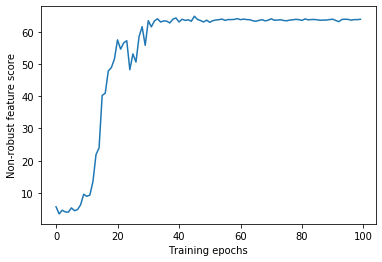

In [18]:
plt.figure()
plt.plot(Test_list)
plt.xlabel("Training epochs")
plt.ylabel("Generalization acc (non-robust feature)")